In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import re
import numpy as np
from PIL import Image

from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [3]:
def read_image(filename, byteorder='>'):
    
    #first we read the image, as a raw file to the buffer
    with open(filename, 'rb') as f:
        buffer = f.read()
    
    #using regex, we extract the header, width, height and maxval of the image
    header, width, height, maxval = re.search(
        b"(^P5\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    
    #then we convert the image to numpy array using np.frombuffer which interprets buffer as one dimensional array
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))

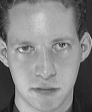

In [4]:
Image.open("att-database-of-faces/s1/3.pgm")

In [5]:
img = read_image('att-database-of-faces/s1/1.pgm')

In [6]:
img.shape

(112, 92)

In [7]:
size = 2
total_sample_size = 10000
n_of_persons = 35

def get_data(size, total_sample_size):
    #read the image
    image = read_image('att-database-of-faces/s' + str(1) + '/' + str(1) + '.pgm', 'rw+')
    #reduce the size
    #image = image[::size, ::size]
    #get the new size
    dim1 = image.shape[0]
    dim2 = image.shape[1]

    count = 0
    
    #initialize the numpy array with the shape of [total_sample, no_of_pairs, dim1, dim2]
    x_geuine_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])  # 2 is for pairs
    y_genuine = np.zeros([total_sample_size, 1])
    
    for i in range(n_of_persons):
        for j in range(int(total_sample_size/n_of_persons)):
            ind1 = 0
            ind2 = 0
            
            #read images from same directory (genuine pair)
            while ind1 == ind2:
                ind1 = np.random.randint(10)
                ind2 = np.random.randint(10)
            
            # read the two images
            img1 = read_image('att-database-of-faces/s' + str(i+1) + '/' + str(ind1 + 1) + '.pgm', 'rw+')
            img2 = read_image('att-database-of-faces/s' + str(i+1) + '/' + str(ind2 + 1) + '.pgm', 'rw+')
            
            #reduce the size
#             img1 = img1[::size, ::size]
#             img2 = img2[::size, ::size]
            
            #store the images to the initialized numpy array
            x_geuine_pair[count, 0, 0, :, :] = img1
            x_geuine_pair[count, 1, 0, :, :] = img2
            
            #as we are drawing images from the same directory we assign label as 1. (genuine pair)
            y_genuine[count] = 1
            count += 1

    count = 0
    x_imposite_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
    y_imposite = np.zeros([total_sample_size, 1])
    
    for i in range(int(total_sample_size/10)):
        for j in range(10):
            
            #read images from different directory (imposite pair)
            while True:
                ind1 = np.random.randint(n_of_persons)
                ind2 = np.random.randint(n_of_persons)
                if ind1 != ind2:
                    break
                    
            img1 = read_image('att-database-of-faces/s' + str(ind1+1) + '/' + str(j + 1) + '.pgm', 'rw+')
            img2 = read_image('att-database-of-faces/s' + str(ind2+1) + '/' + str(j + 1) + '.pgm', 'rw+')

#             img1 = img1[::size, ::size]
#             img2 = img2[::size, ::size]

            x_imposite_pair[count, 0, 0, :, :] = img1
            x_imposite_pair[count, 1, 0, :, :] = img2
            #as we are drawing images from the different directory we assign label as 0. (imposite pair)
            y_imposite[count] = 0
            count += 1
            
    #now, concatenate, genuine pairs and imposite pair to get the whole data
    X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y

In [8]:
X, Y = get_data(size, total_sample_size)

In [9]:
X.shape

(20000, 2, 1, 112, 92)

In [10]:
Y.shape

(20000, 1)

Next, we split our data for training and testing with 75% training and 25% testing proportions:

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.25)

In [12]:
def build_base_network(input_shape):
    
    seq = Sequential()
    
    nb_filter = [6, 12]
    kernel_size = 3
    
    
    #convolutional layer 1
    seq.add(Convolution2D(nb_filter[0], kernel_size, kernel_size, input_shape=input_shape,
                          border_mode='valid', dim_ordering='th'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))  
    seq.add(Dropout(.25))
    
    #convolutional layer 2
    seq.add(Convolution2D(nb_filter[1], kernel_size, kernel_size, border_mode='valid', dim_ordering='th'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='th')) 
    seq.add(Dropout(.25))

    #flatten 
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(50, activation='relu'))
    return seq


In [13]:
input_dim = x_train.shape[2:]
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

In [14]:
base_network = build_base_network(input_dim)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

In [15]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [16]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

In [17]:
epochs = 5
rms = RMSprop()

In [18]:
model = Model(input=[img_a, img_b], output=distance)

Next, we define our loss function as contrastive_loss function and compile the model. 

In [19]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [20]:
model.compile(loss=contrastive_loss, optimizer=rms)

In [21]:
img_1 = x_train[:, 0]
img2 = x_train[:, 1]

In [22]:
model.fit([img_1, img2], y_train, validation_split=.25,
          batch_size=128, verbose=1, nb_epoch=epochs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 11250 samples, validate on 3750 samples
Epoch 1/5
11250/11250 [==============================] - 171s 15ms/step - loss: 0.2194 - val_loss: 0.1528
Epoch 2/5
11250/11250 [==============================] - 180s 16ms/step - loss: 0.0871 - val_loss: 0.0812
Epoch 3/5
11250/11250 [==============================] - 261s 23ms/step - loss: 0.0622 - val_loss: 0.0510
Epoch 4/5
11250/11250 [==============================] - 171s 15ms/step - loss: 0.0510 - val_loss: 0.0401
Epoch 5/5
11250/11250 [==============================] - 148s 13ms/step - loss: 0.0432 - val_loss: 0.0430


Now, we make predictions with test data

In [23]:
pred = model.predict([x_test[:, 0], x_test[:, 1]])

In [26]:
def compute_accuracy(predictions, labels):
    return labels[predictions.ravel() < 0.5].mean()

Finally, we check our model accuracy. 

In [27]:
compute_accuracy(pred, y_test)

0.9041044776119403

In [28]:
model.save('face_model.h5')

In [29]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 112, 92)   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1, 112, 92)   0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 50)           1764158     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           sequential_1[1][0]         